In [163]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import csv
import time
from scipy.stats import pearsonr
from flopy.utils.sfroutputfile import SfrFile

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

import importlib
import treeFuncs
from treeFuncs import trainAndEvaluateModel 
from treeFuncs import metrics


modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput/transientDrawdown"
#modws= "D:/mfoutput/transientSeasons"

In [66]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio']#, 'Qout']

# load output from modflow simulations
outputdf = pd.read_csv('outputs/TransOutputStpSteadyPumpTest.csv') 
#outputdf = pd.read_csv('outputs/TransSeasonsOutputStpTest.csv') #output

#load parameters
sampling = np.loadtxt("params/ModflowParams7-750Test12.txt") 
print(sampling)
pardf = pd.DataFrame(sampling, columns = col_names)

outputdf = outputdf[['simnum','Qout','reach','Stp']].reset_index() #only keep the cols we need

#Drawdown scenario steps
numTS = 5 #number of time steps to keep from the end
stps = 5 - numTS

#Seasonal Scenario Steps
#numTS = 6 #number of time steps to keep from the end
#stps = 41 - numTS

StrPer = [i+1 for i in range(stps, stps+numTS)]
print(StrPer)
outputdf = outputdf[outputdf['Stp'] > stps].set_index(['Stp','simnum','reach']) #grab data from the last 5 stress periods and set index to simulation
simindex = outputdf.index.get_level_values('simnum').unique()
timestepidx = outputdf['index'].unique()
idx = pd.IndexSlice

pardf = pardf.iloc[simindex]
outputdf = outputdf.drop('index', axis=1).unstack('reach')
#print(outputdf.columns)
outputdf = outputdf.droplevel(0, axis=1)
#display(outputdf[25])

[[3.19247919e-01 1.88302730e-04 1.37480374e-01 ... 1.60372088e-06
  4.69038871e+00 1.63449723e-02]
 [2.52595828e-01 7.43633707e-05 5.80341431e-02 ... 8.79813703e-06
  3.18511742e+00 1.12193189e-02]
 [4.25212558e-01 7.61486276e-01 1.08251212e-01 ... 2.16034275e-06
  2.18084489e+00 1.21442097e-03]
 ...
 [4.39468577e-01 6.13132403e-02 2.12593341e-01 ... 3.75793109e-06
  1.89596277e+00 4.01859879e-02]
 [2.86647520e-01 1.19454051e-05 9.47905228e-02 ... 1.42520917e-06
  2.77129655e+00 7.38527223e-02]
 [2.63331106e-01 2.82770295e-05 1.23301509e-01 ... 6.47036236e-06
  1.38885456e+00 1.12791618e-03]]
[1, 2, 3, 4, 5]


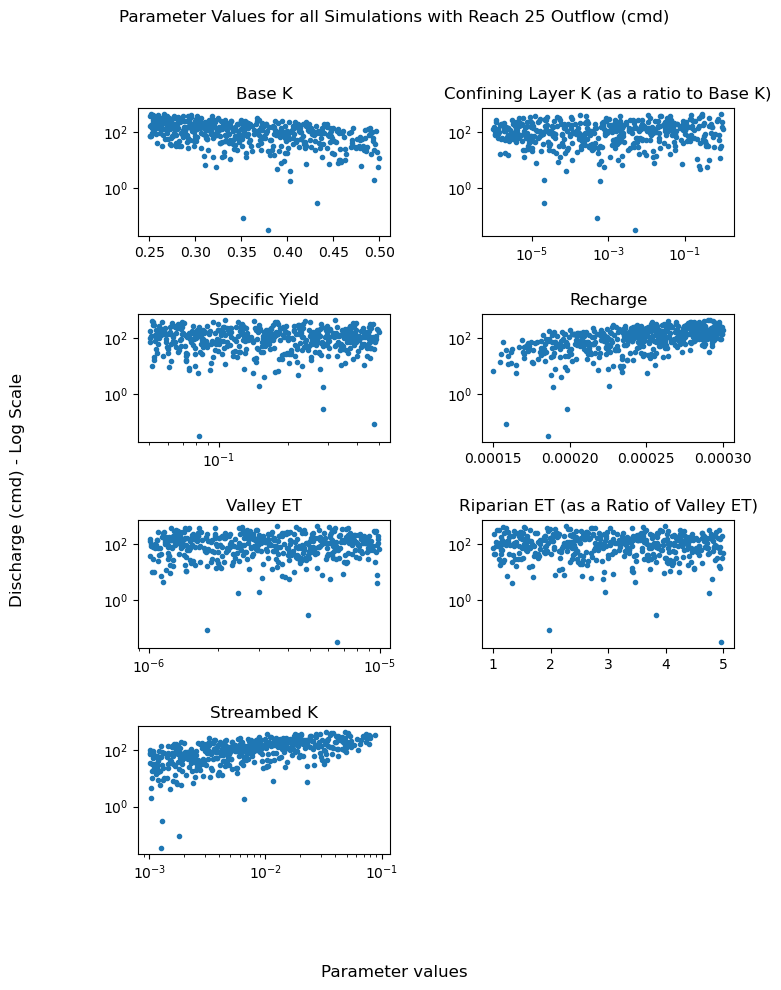

In [68]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio', 'Qout']
col_dict = {'K':'Base K', 'Low_K_ratio': 'Confining Layer K (as a ratio to Base K)', 'Sy':'Specific Yield', 'Rech':'Recharge', 'ET_valley':'Valley ET', 'ET_rip_ratio':'Riparian ET (as a Ratio of Valley ET)', 'Stream_K_ratio':'Streambed K'}


params = pardf
rn = 25
ReachQdf = outputdf.loc[idx[StrPer[-1]],[rn]] #last stressperiod Qout for reach rn
#display(ReachQdf)

fig, axs = plt.subplots(4, 2, sharex=False, sharey=False,figsize=(8, 10))
fig.suptitle('Parameter Values for all Simulations with Reach 25 Outflow (cmd)')
fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Parameter values')
fig.tight_layout(pad = 3.5)
fig.delaxes(axs[3,1])
# for i in range(len(col_names) - 1):
#     axs.plot(X[col_names[i]],Y,'k.')
i=0
logpars = [1,2,4,6]
for row in axs:
    for col in row: 
        col.plot(params[col_names[i]],ReachQdf,'.')
        col.title.set_text(col_dict[col_names[i]])
        if i in logpars:
            col.set_xscale('log')
        col.set_yscale('log')
        if i < (len(col_names)-2):
            i+=1
        else:
            break

array([165.29, 153.91, 147.95, 145.04, 142.61])

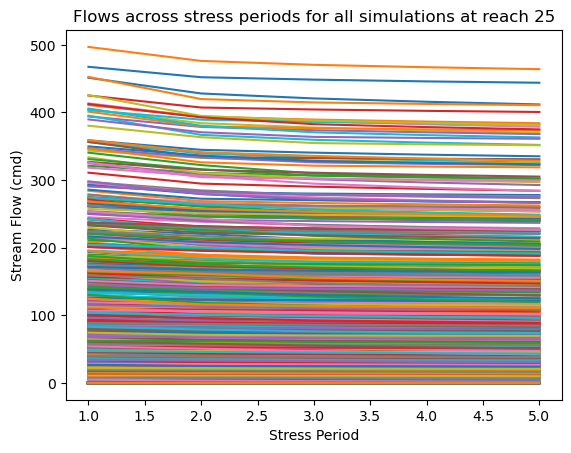

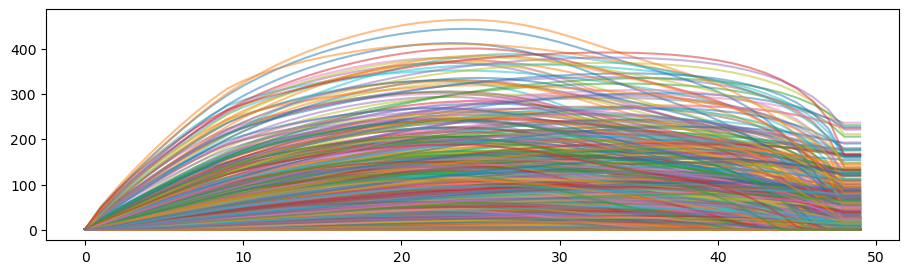

In [70]:
rn = 25
outputs = outputdf[rn]
display(outputs.xs(1,level=1).values.flatten())
#outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this

#print(outputs)
#print(outputs.index.get_level_values('simnum').unique())
for i in outputs.index.get_level_values('simnum').unique():#range(int(len(outputs)/10)):
    plt.plot(StrPer,outputs.xs(i,level=1).values.flatten())
plt.xlabel("Stress Period")
plt.ylabel("Stream Flow (cmd)")
plt.title("Flows across stress periods for all simulations at reach " + str(rn))
#plt.ylim([-10,450])
#plt.yscale('log')
#plt.xticks([i for i in range(0, numTS)])
#plt.legend()
plt.show()


#reachQ = outputdf.xs(StrPer[0],level='Stp')
#display(reachQ)

plt.figure(figsize=(11,3))
for i in outputs.index.get_level_values('simnum').unique():#range(int(len(outputs)/10)):
    plt.plot(range(0,50),outputdf.loc[idx[StrPer[-1],i]],alpha=0.5)
   # plt.plot(range(0,50),outputdf.loc[idx[StrPer[0],i,:]]['Qout'],color='r',alpha=0.75)

16
1
1
1
16
16
(595, 50)


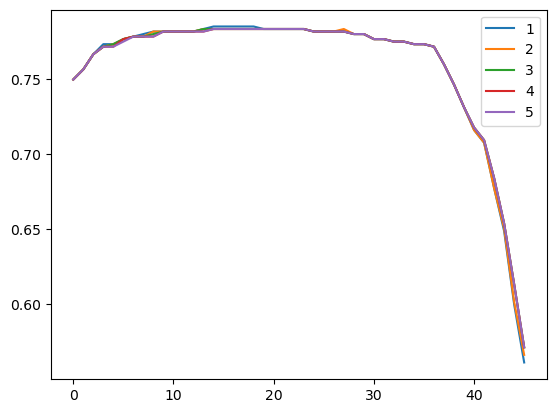

In [71]:
#Getting rid of ensembles with 0 flow
rn = 25

for i in StrPer:
    ReachQdf = outputdf.xs(i,level='Stp')

    numgrz = [np.sum(ReachQdf[k] > 0) / len(ReachQdf.index) for k in range(1,51)] 
    print(numgrz.index(max(numgrz[2:])))
    plt.plot(numgrz[2:48], label=i)
   # print(ReachQdf.index)
#ReachQdf = pd.DataFrame(np.asarray(outputdf[outputdf['Stp'] == 5]['Qout']).reshape((len(simindex),50))) #this is ugly
plt.legend()
#numgrz = [len(ReachQdf[i][ReachQdf[i] > 0].index)/len(ReachQdf.index) for i in range(50)] 
#print(numgrz.index(max(numgrz)))

#print(ReachQdf.index)

rn_highest = numgrz.index(max(numgrz[2:])) #find reach with greatest number of wet ensembles 
#ReachQdf = ReachQdf[ReachQdf[rn_highest] > 0]
print(rn_highest)
print(ReachQdf.shape)


In [72]:
#New way of pulling out simulations that are dry using multi-level index

print(outputdf.index.get_level_values('simnum'))

HighRn = outputdf[rn_highest] #get a slice of the highest reach Qout
grtzSims = HighRn[HighRn > 0].index.get_level_values('simnum').unique().values
print(len(grtzSims))
idx = pd.IndexSlice #makes slicing multilevel indexs easier
RevisedOutputdf = outputdf.loc[idx[:,grtzSims,:] , :]
#display(RevisedOutputdf)
display(outputdf)
pardf = pardf.loc[grtzSims]


Int64Index([  1,   2,   3,   4,   6,   7,   8,   9,  10,  11,
            ...
            739, 740, 741, 742, 743, 744, 745, 747, 748, 749],
           dtype='int64', name='simnum', length=2975)
466


reach        1        2        3         4         5         6         7   \
Stp simnum                                                                  
1   1       1.0  11.8290  22.5360   33.3560   44.2930   55.2820   66.2220   
    2       1.0   3.0645   5.2555    7.5655    9.9810   12.4860   15.0610   
    3       1.0   2.4390   4.0049    5.6870    7.4712    9.3409   11.2780   
    4       1.0   0.0000   0.0000    0.0000    0.0000    0.0000    0.0000   
    6       1.0   4.3860   8.0083   11.8630   15.9240   20.1520   24.5030   
...         ...      ...      ...       ...       ...       ...       ...   
5   744     1.0   1.0686   1.4518    2.0984    2.9661    4.0162    5.2113   
    745     1.0   0.0000   0.0000    0.0000    0.0000    0.0000    0.0000   
    747     1.0  20.0100  36.4770   52.3430   67.9790   83.3890   98.4380   
    748     1.0  48.7150  84.9300  117.2700  147.3100  175.4500  201.6500   
    749     1.0   1.9409   3.0048    4.1726    5.4258    6.7456    8.1113   

reach             8         9         10  ...       41       42        43  \
Stp simnum                                ...                               
1   1        76.9950   87.4590   97.4080  ...  145.160  139.700  133.3000   
    2        17.6850   20.3360   22.9870  ...   68.260   67.042   65.4760   
    3        13.2630   15.2740   17.2860  ...   45.423   44.101   42.4920   
    4         0.0000    0.0000    0.0000  ...    0.000    0.000    0.0000   
    6        28.9300   33.3780   37.7850  ...  102.340  100.160   97.3340   
...              ...       ...       ...  ...      ...      ...       ...   
5   744       6.5129    7.8819    9.2767  ...   12.369   10.136    7.5342   
    745       0.0000    0.0000    0.0000  ...    0.000    0.000    0.0000   
    747     112.9200  126.5700  139.0800  ...   72.666   57.805   40.3510   
    748     225.6200  246.9400  264.9800  ...  374.420  367.400  358.3800   
    749       9.5009   10.8910   12.2620  ...   37.129   36.566   35.7730   

reach             44         45         46         47       48       49  \
Stp simnum                                                                
1   1       125.7700  116.81000  105.97000   92.50600   74.972   52.979   
    2        63.5280   61.23300   58.94700   56.66900   54.402   52.145   
    3        40.5660   38.57700   36.59800   34.63000   32.675   30.732   
    4         0.0000    0.00000    0.00000    0.00000    0.000    0.000   
    6        93.7580   89.28900   83.74600   76.87300   69.888   63.063   
...              ...        ...        ...        ...      ...      ...   
5   744       4.6471    2.02710    0.31401    0.22101    0.000    0.000   
    745       0.0000    0.00000    0.00000    0.00000    0.000    0.000   
    747      20.1350    0.44757    0.00000    0.00000    0.000    0.000   
    748     346.8000  331.79000  312.02000  284.88000  244.080  165.480   
    749      34.7080   33.32500   31.64200   29.96700   28.304   26.655   

reach            50  
Stp simnum           
1   1        52.979  
    2        52.145  
    3        30.732  
    4         0.000  
    6        63.063  
...             ...  
5   744       0.000  
    745       0.000  
    747       0.000  
    748     165.720  
    749      26.785  

[2975 rows x 50 columns]

# Decision Tree Code
Most of below is from:https://www.datacamp.com/community/tutorials/decision-tree-classification-python

In [73]:
#Testing using the multilevel index to get Qout for each stress period
outputs = RevisedOutputdf[25].unstack(level='Stp')
display(outputs)

Stp           1        2        3        4        5
simnum                                             
1       165.290  153.910  147.950  145.040  142.610
2        57.733   56.607   55.750   55.124   54.620
3        42.065   41.461   41.011   40.646   40.315
6        89.943   88.102   86.108   85.306   84.715
7       271.410  262.330  258.640  256.000  253.770
...         ...      ...      ...      ...      ...
743      47.107   45.898   44.913   44.029   43.335
744      26.724   25.098   24.559   24.264   24.040
747     220.660  213.150  209.450  206.670  204.390
748     412.350  392.790  382.650  378.370  374.970
749      33.957   33.184   32.360   31.634   31.214

[466 rows x 5 columns]

Shape of Input Samples: (466, 7)
Shape of Output Targets: (466, 5)
Plot showing just simulaions with Q > 0


Stp           1        2        3        4        5
simnum                                             
344     180.280  172.570  169.130  167.380  166.050
64       12.976   12.528   11.827   11.182   10.604
312      32.415   31.210   29.754   28.492   27.401
20      113.930  107.270  104.370  102.530  100.930
253      99.540   96.118   92.941   91.433   90.507
...         ...      ...      ...      ...      ...
212     144.670  140.450  139.080  137.890  136.880
593     120.050  116.050  112.940  110.430  108.460
480     106.600   97.071   94.182   92.211   90.535
675     123.200  116.600  113.380  110.720  108.600
682      86.692   84.961   84.067   83.476   83.040

[94 rows x 5 columns]

Stp           1        2        3        4        5
simnum                                             
344     195.200  183.660  178.870  176.890  175.390
64       12.019   11.451   10.994   10.616   10.280
312      22.182   20.869   19.532   18.376   17.351
20       88.701   87.950   84.505   81.681   79.172
253     119.100  111.880  110.350  109.730  109.230
...         ...      ...      ...      ...      ...
212     165.390  159.950  157.770  156.080  154.610
593     113.100  111.770  109.780  108.670  107.730
480      73.840   72.177   70.697   69.610   68.701
675     161.980  154.580  151.360  148.980  146.900
682      82.890   80.473   78.682   77.367   76.299

[94 rows x 5 columns]

389.73


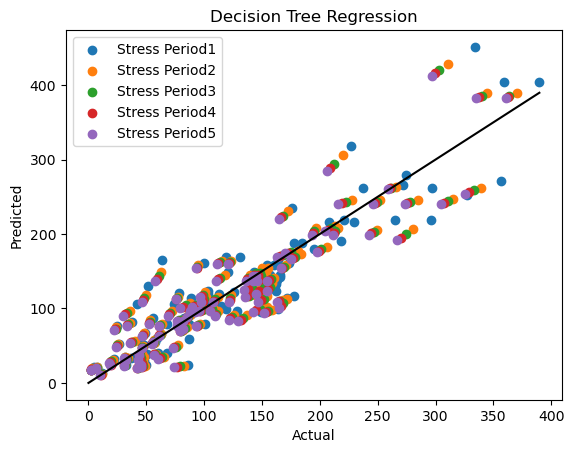

       bias       rmse         r       nse       kge
0 -0.679848  36.465515  0.913800  0.828044  0.913583
1 -0.493276  34.532469  0.914875  0.829618  0.914776
2 -0.519563  33.968840  0.915048  0.829141  0.914776
3 -0.471918  33.616668  0.915449  0.829764  0.915121
4 -0.434743  33.344471  0.915711  0.830175  0.915343


In [93]:
# Split dataset into training set and test set, default here is 30% test
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel
rn  = 25 #reach number
#old way
#outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this
#New way
outputs = RevisedOutputdf[rn].unstack(level='Stp')

pars = None
n=1

impdf, metricsdf, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, pardf, outputs, pars, 0.2, n)

print('Plot showing just simulaions with Q > 0')
# Plot the results
plt.figure()

#print(y_test,y_pred.flatten())
#for i in range(1,numTS+1):
display(y_pred)
display(y_test)
for i in y_test.columns:
    plt.scatter(y_test[i], y_pred[i], label = "Stress Period"+str(i))
outmax =np.max(y_test.max())
print(outmax)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

print(metricsdf)


K                 0.276225
Low_K_ratio       0.004695
Sy                0.009846
Rech              0.242121
ET_valley         0.004011
ET_rip_ratio      0.008296
Stream_K_ratio    0.454807
Name: 0, dtype: float64

<Axes: >

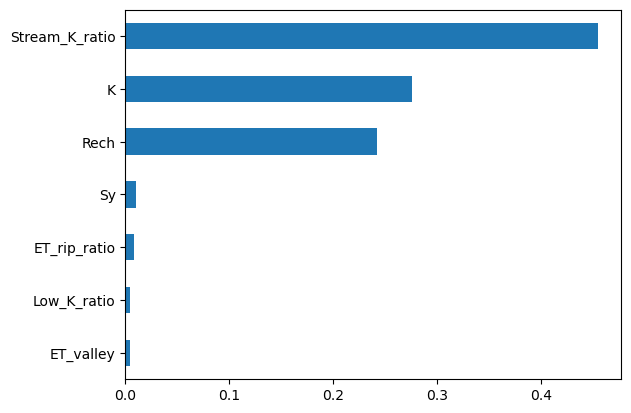

In [16]:
#evalTree(clf)
display(impdf[0])
impdf.loc[:,0].sort_values().plot(kind='barh')

In [236]:
# #feature importance
# importance = clf.feature_importances_
# print(importance)
# imp_names = clf.feature_names_in_
# print(imp_names)
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# # plt.bar([x for x in range(len(importance))], importance)
# # plt.show()

# feat_importances = pd.Series(clf.feature_importances_, index=clf.feature_names_in_)
# feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
#try to predict Qout with parameters at every reach
reachnum = 50
Reach_importance = []
nse_list = []
simnum = []

for i in range(1,reachnum):
    
    Y3 = np.asarray(outputdf[outputdf['reach'] == i]['Qout']).reshape((len(simindex),numTS))#[:,1] #probably a better way to do this

    X3 = pardf
    
   # numgrz = np.where(Y3 > 0) 
   # print('Number of simulations > 0 : ' + str(numgrz))
    
    # Split dataset into training set and test set, default here is 30% test
    X_train, X_test, y_train, y_test = train_test_split(X3, Y3, test_size=0.3, random_state=0)

    # Create Decision Tree classifer object
    reachTree = DecisionTreeRegressor(
        #random_state = 0
         #max_depth = 9
    )

    # Train Decision Tree Classifer
    reachTree = reachTree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = reachTree.predict(X_test)

    #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#     print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
#     print("NSE: ", NSE(y_test, y_pred))
#     print("Tree Depth: ", reachTree.get_depth())
    #print("Reach "+str(i)+" RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
    print("Reach "+str(i) + " NSE: ", NSE(y_pred, y_test))
    nse_list.append(NSE(y_pred, y_test))
   # simnum.append(numgrz)
    # Plot the results
    #plt.figure()
    label = "Reach " + str(i)
    plt.scatter(y_test, y_pred, label = label)  

   #plt.legend()


    #feature importance
    importance = reachTree.feature_importances_
    Reach_importance.append(importance)

#outmax = np.max(ReachQ)
outmax = 1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
#plt.legend()
plt.show()

plt.plot(nse_list, 'k.')

plt.xlabel("Reach Number")
plt.ylabel("NSE")
plt.title("Result for each Reach (cell)")
plt.show()

#feature importance
importance = reachTree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

feat_importances = pd.Series(reachTree.feature_importances_, index=reachTree.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh',)
plt.xlabel('Importance Value')
#plt.ylabel('ylabel')
plt.show()
# plt.plot(simnum)

# plt.xlabel("Reach Number")
# plt.ylabel("Number of Simulations with Q > 0")
# plt.title("Number of non-dry simulations for each Reach (cell)")
# plt.show()

## Now for the Wells

In [94]:
#all_well_loc = np.array(np.meshgrid(np.arange(50),np.arange(50))).T.reshape(-1,2)
#print(all_well_loc)

#load in Ibound and find active cells in model - then put it into a list of well locations
ibound = np.loadtxt('base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T

#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_head = np.empty((all_well_loc.shape[0], len(grtzSims),numTS))



In [4]:
# #Cell block for test head object out put - can ignore 

# modelname = "ScenarioSfr750Seasons_"+str(simindex[0])
# headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
# head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
# print(head.shape)
# print(head[::30,21,32][-6:])
# headtimes = np.array(headobj.get_times())
# print(headtimes)

# print(headtimes[::30])
# print(len(headtimes[::30]))

# headts = headobj.get_ts([(0,21,32)])
# #headts[10:,0] = (headts[10:,0] / 6) * 50  *2
# print(headts[::30][-numTS:].astype('int'))
# print(headobj.get_ts([(0,21,32)])[::30,1][-numTS:].astype('int'))


# print(len(headts))
# headstp = np.divmod(np.arange(len(headts)-10),30*2)[0]+1

# plt.plot(headts[::30,1])
# plt.show()
# plt.plot(headts[:,1])

In [405]:
#Get Head data for All active wells
#import seaborn as sns
sns.set_style("white")
modws= "D:/mfoutput/transientSeasons"
#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_error_sim = []
#well_error_num = []

for j, i in enumerate(grtzSims):
    modelname = "ScenarioSfr750SeasonsTest_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
#     for k in range(all_well_loc.shape[0]):
#         well_head[k][j][:] = headobj.get_ts([(0,int(all_well_loc[k][0]),int(all_well_loc[k][1]))])[::30,1][-numTS:] #complicated way of getting all the heads (numTS) by sampling every 30 of the head ts foreach well
#         if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
#                 well_error_sim.append(i)              
                
    head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
    for k in range(all_well_loc.shape[0]): #grabbing the last n Stress periods (-numTS)
            well_head[k][j][:] = head[::30,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would 
           # well_head[k][j][1] = head[-1][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would  be 60
            if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
                well_error_sim.append(i)
print("Done")          

Done


In [95]:
## Delete out simulations where well head is twice the average
print(well_head.shape)
#print(well_head.transpose(1,0,2).reshape(len(simindex),well_head.shape[0]*numTS))
RevisedPardf = pardf.loc[~pardf.index.isin(np.unique(well_error_sim))]
#new_zone.head
well_head_df = pd.DataFrame(well_head.transpose(1,0,2).reshape(len(grtzSims),well_head.shape[0]*numTS),index=grtzSims)#, index = pardf.index) #put the wwells into an unput that has each stress period so now input os 4024 long
display(well_head_df)
print(len(well_head_df.index))

#well_head_df.to_pickle('outputs/heads/Well_head_seasons.pkl')
#RevisedPardf.to_pickle('params/Seasons_pardf.pkl')   
print(len(well_head_df.index))
print(RevisedPardf)




(2012, 466, 5)


NameError: name 'well_error_sim' is not defined

In [97]:
#Only necessary if pulling well_head_df from pkl or csv

well_head_df = pd.read_pickle('outputs/heads/Well_head_drawdown.pkl')
#well_head_df = pd.read_pickle('outputs/heads/Well_head_seasons.pkl')

new_zone = pd.read_pickle('params/Drawdown_pardf.pkl')
#new_zone = pd.read_pickle('params/Seasons_pardf.pkl')

well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_heads_loc = np.arange(all_well_loc.shape[0]*numTS).reshape((int(all_well_loc.shape[0]),numTS)) #splits the well head_df into subsets aplicable to the location (so we ahve numTS outputs)

wellnums_arr = np.arange(well_head.shape[0])
stps_arr = StrPer
column_idx = pd.MultiIndex.from_product([wellnums_arr.astype('str'), stps_arr],
                           names=['wellnum', 'Stp'])
well_head_df.columns = column_idx

display(well_head_df)

wellnum           0                                                  \
Stp               1           2           3           4           5   
1        100.182137  100.151459  100.074760   99.995934   99.919518   
2        100.352928  100.352882  100.352730  100.352173  100.350594   
3         98.814423   98.814430   98.814430   98.814430   98.814430   
6         98.153801   98.151497   98.136505   98.110863   98.080612   
7        100.766068  100.766083  100.766083  100.766083  100.765961   
..              ...         ...         ...         ...         ...   
743       94.450165   94.439278   94.399368   94.351379   94.303528   
744       93.850105   93.850075   93.849487   93.848282   93.846642   
747       98.038101   98.038109   98.038109   98.038109   98.038109   
748      103.616188  103.592354  103.514404  103.426140  103.339493   
749       97.303268   97.295593   97.257370   97.204056   97.147476   

wellnum           1                                                  ...  \
Stp               1           2           3           4           5  ...   
1         99.934296   99.886238   99.801285   99.720131   99.642906  ...   
2        100.121155  100.121094  100.120926  100.120293  100.118484  ...   
3         98.587891   98.587914   98.587914   98.587914   98.587914  ...   
6         97.936050   97.928871   97.902939   97.869804   97.835136  ...   
7        100.529915  100.529922  100.529922  100.529922  100.529739  ...   
..              ...         ...         ...         ...         ...  ...   
743       94.255020   94.232834   94.182503   94.130486   94.081001  ...   
744       93.659660   93.659386   93.658188   93.656395   93.654335  ...   
747       97.822708   97.822708   97.822708   97.822708   97.822708  ...   
748      103.345573  103.302048  103.208923  103.115524  103.027023  ...   
749       97.089455   97.070824   97.016594   96.955391   96.895004  ...   

wellnum       2010                                                   2011  \
Stp              1          2          3          4          5          1   
1        94.085373  94.076775  94.063240  94.044838  94.021790  93.755791   
2        94.645020  94.644997  94.644119  94.641006  94.635124  94.319901   
3        93.098053  93.098053  93.098053  93.098053  93.098053  92.775040   
6        93.077477  93.076500  93.075111  93.073524  93.071472  92.795364   
7        94.802879  94.802872  94.802742  94.802155  94.800896  94.476067   
..             ...        ...        ...        ...        ...        ...   
743      89.977989  89.975838  89.972702  89.968193  89.961975  89.727676   
744      89.209114  89.208420  89.207581  89.206696  89.205750  88.942978   
747      92.660431  92.660431  92.660431  92.660408  92.660217  92.363533   
748      97.179344  97.177948  97.174080  97.165894  97.152657  96.851295   
749      92.265259  92.262970  92.259483  92.255013  92.249039  91.981522   

wellnum                                              
Stp              2          3          4          5  
1        93.746704  93.733315  93.715607  93.693268  
2        94.319878  94.318909  94.315559  94.309311  
3        92.775024  92.775024  92.775024  92.775024  
6        92.794357  92.792892  92.791344  92.789467  
7        94.476051  94.475899  94.475250  94.473869  
..             ...        ...        ...        ...  
743      89.725426  89.722351  89.718346  89.712906  
744      88.942116  88.941200  88.940239  88.939224  
747      92.363533  92.363533  92.363503  92.363297  
748      96.849831  96.846504  96.839722  96.828262  
749      91.979088  91.975517  91.971352  91.966057  

[466 rows x 10060 columns]

In [98]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import wellmesh_correlation


#only get the heads for a certain TS - this is a little convoluted but it's what I had already
test_head = well_head_df.to_numpy().reshape((len(grtzSims),well_head.shape[0],numTS))
Stp_head_df = pd.DataFrame(test_head[:,:,-1])

with pd.option_context('display.max_rows', 8, 'display.max_columns', 8):
    display(Stp_head_df)


wellmesh_corr = wellmesh_correlation(all_well_loc,Stp_head_df)

0           1           2           3     ...       2008  \
0     99.919518   99.642906   99.184723   98.620682  ...  94.969688   
1    100.350594  100.118484   99.735626   99.264397  ...  95.574097   
2     98.814430   98.587914   98.213982   97.754440  ...  94.031517   
3     98.080612   97.835136   97.425468   96.917816  ...  93.882454   
..          ...         ...         ...         ...  ...        ...   
462   93.846642   93.654335   93.337029   92.949615  ...  89.973900   
463   98.038109   97.822708   97.466560   97.028938  ...  93.520744   
464  103.339493  103.027023  102.506897  101.862473  ...  98.090294   
465   97.147476   96.895004   96.475441   95.958733  ...  93.058990   

          2009       2010       2011  
0    94.470497  94.021790  93.693268  
1    95.079651  94.635124  94.309311  
2    93.539566  93.098053  92.775024  
3    93.455894  93.071472  92.789467  
..         ...        ...        ...  
462  89.569450  89.205750  88.939224  
463  93.066765  92.660217  92.363297  
464  97.596291  97.152657  96.828262  
465  92.633774  92.249039  91.966057  

[466 rows x 2012 columns]

[[4.53372723 4.53304706 4.53370194 4.53318395 4.53401232 4.53364288]
 [4.50758752 4.50781613 4.50761659 4.50801365 4.50798081 4.50853454]
 [4.4627622  4.46624715 4.46287405 4.46655097 4.46332227 4.46717942]
 ...
 [3.71979708 3.71889281 3.71854344 3.71784357 3.71766156 3.71715547]
 [3.6585708  3.65752507 3.65742336 3.65658964 3.6566449  3.65601102]
 [3.61439042 3.61298919 3.61333121 3.61215532 3.61263844 3.61167139]]


C:\Users\davem\AppData\Local\Temp\ipykernel_18204\95687791.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


<Figure size 800x600 with 0 Axes>

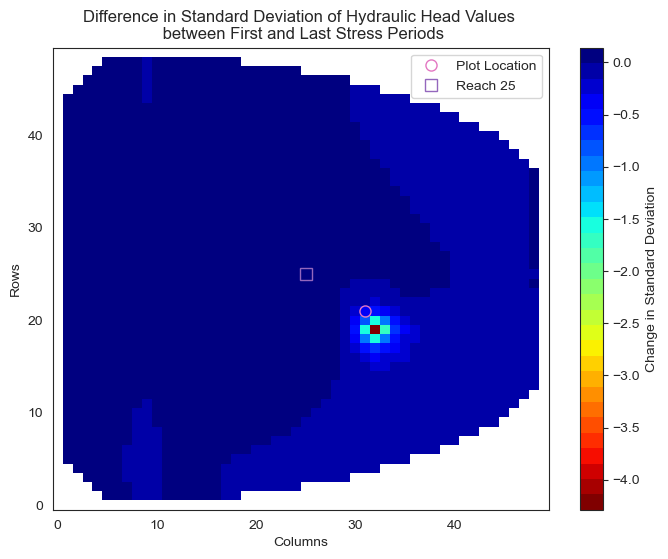

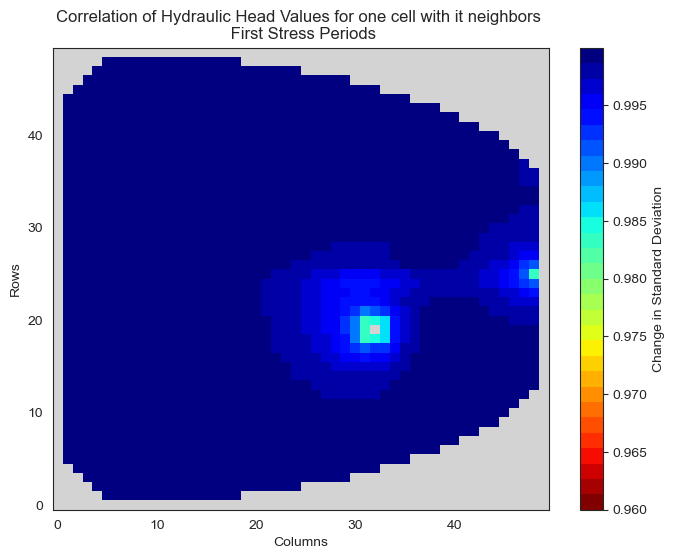

In [410]:
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm
wn = 844

kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

test_head = well_head_df.to_numpy().reshape((len(grtzSims),well_head.shape[0],numTS))
#print(test_head)
# well_head_var = test.var(axis=(0,1))
# print(well_head_var.shape)
# #print(well_head_var)
well_head_var = np.empty((well_head.shape[0],numTS))

for i in range(well_head.shape[0]):
    for k in range(numTS):
        well_head_var[i][k] = np.std(test_head[:,i,k])
        
print(well_head_var)
wellmesh = np.ndarray((numTS,50,50))
wellmesh[:][:][:] = -1e30

for i in range(all_well_loc.shape[0]):
    wellmesh[:,int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_var[i]

#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("lightgrey")


plt.figure(figsize=(8,6))

# for i in range(numTS):
#     plt.figure(figsize=(8,6))
#     plt.pcolormesh(KK,GG,wellmesh[i], vmax = 6,cmap = cmap2, vmin = 0,shading='nearest')
#     plt.colorbar(label = 'Std')
#     plt.xlabel('Columns')
#     plt.ylabel('Rows')
#     plt.title('Standard Deviation of the head values across the simulations \n Stress Period: ' +str(i +1))
#     plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
wm_dif = wellmesh[0]-wellmesh[-1]
wm_dif = np.ma.masked_array(wm_dif, wellmesh[0] < 0)
#plt.imshow(wellmesh, cmap='RdBu')
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wm_dif, cmap = cmap2, shading='nearest')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="tab:pink", mfc='none', linestyle = "None", label="Plot Location")
#plt.plot(range(1,49),river, color="lightblue",label='River')
plt.plot(25,25, marker="s", markersize=8, color="tab:purple", mfc='none', linestyle = "None", label="Reach 25")

#plt.plot(31, 20, marker="x", markersize=8, color="White", linestyle = "None", label="Obs")
plt.colorbar(label = 'Change in Standard Deviation')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Difference in Standard Deviation of Hydraulic Head Values \n between First and Last Stress Periods')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_corr, cmap = cmap2,vmin = 0.96, shading='nearest')
#plt.plot(31, 20, marker="x", markersize=8, color="White", linestyle = "None", label="Obs")
plt.colorbar(label = 'Change in Standard Deviation')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Correlation of Hydraulic Head Values for one cell with it neighbors \n First Stress Periods')
plt.show()


2012


C:\Users\davem\AppData\Local\Temp\ipykernel_18216\462508883.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=10)


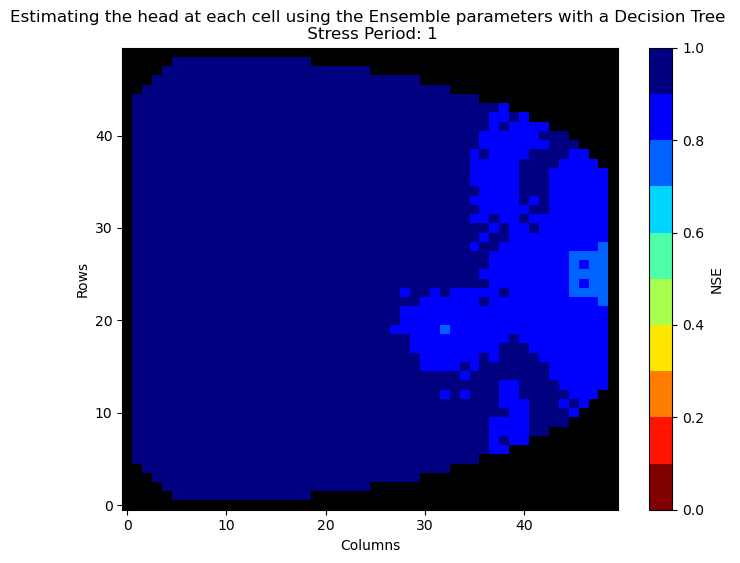

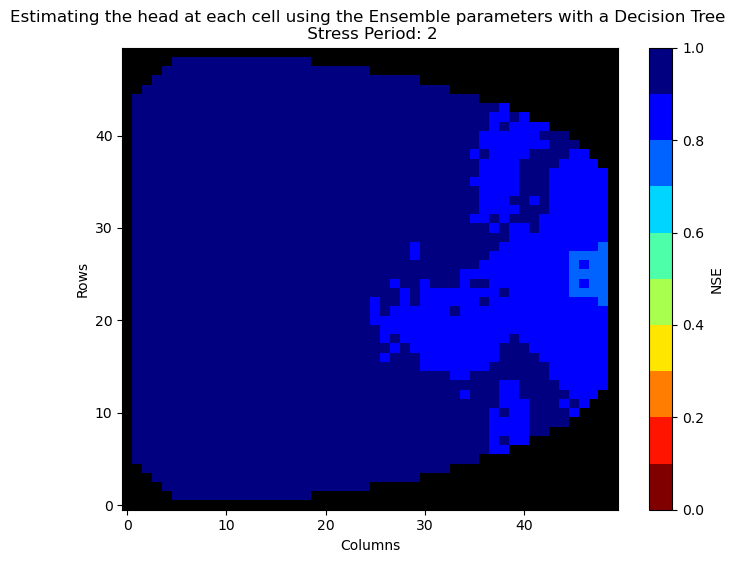

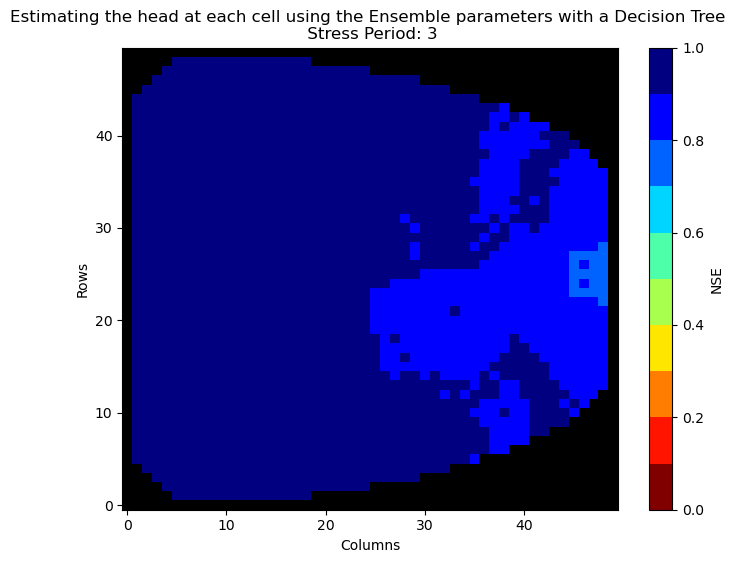

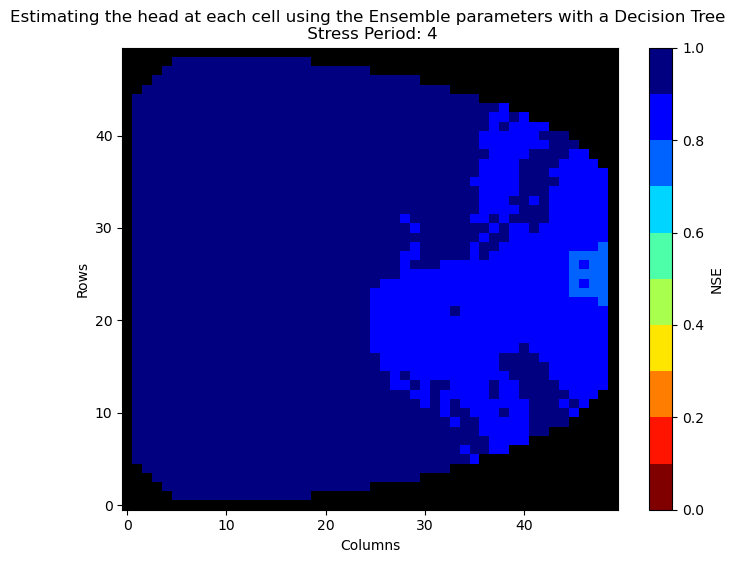

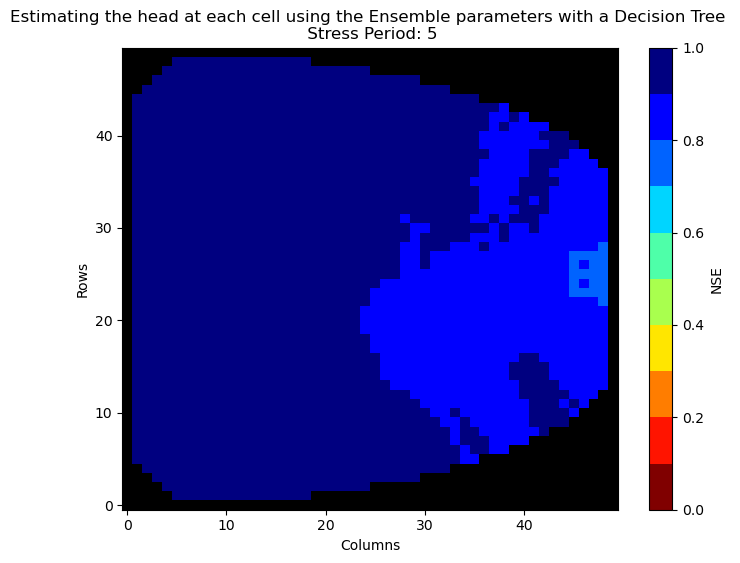

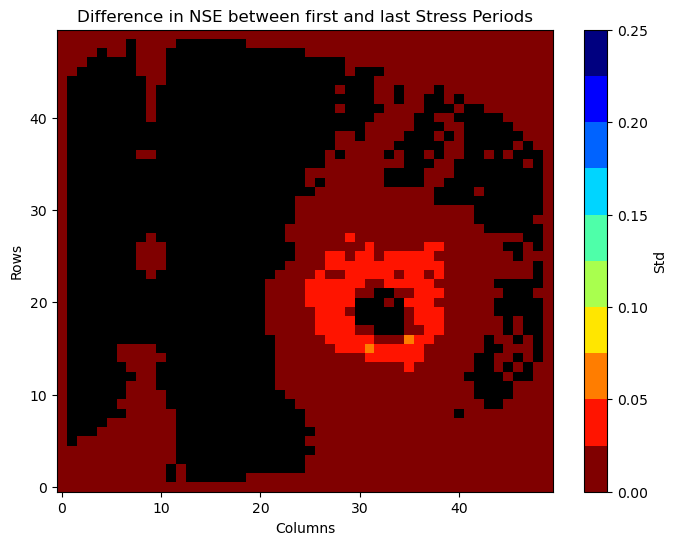

In [19]:


nse_list_remove = nse_list#[-50 if (np.any(np.isinf(x)) or np.any(np.isnan(x))) else x for x in nse_list] #np.any only nessesay if pasing NSE for each stress period individually 
#s = np.isnan(nse_list_remove)
nse_list_remove = np.reshape(nse_list_remove,(len(nse_list_remove),numTS))

print(len(nse_list_remove))

wellmesh = np.ndarray((numTS,50,50))
wellmesh[:] = -1e30

for k in range(numTS):
    for i in range(all_well_loc.shape[0]):
        wellmesh[k][int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = nse_list_remove[i][k]
        
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=10)
cmap2.set_under("k")

#plt.figure(figsize=(8,6))
for i in range(numTS):
    plt.figure(figsize=(8,6))
    plt.pcolormesh(KK,GG,wellmesh[i], vmax = 1,cmap = cmap2, vmin = 0,shading='nearest')  
    plt.colorbar(label = 'NSE')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Estimating the head at each cell using the Ensemble parameters with a Decision Tree \n Stress Period: ' +str(i +1))
    #plt.pcolormesh(KK,GG,wellmesh, vmax = 1,cmap = cmap2, vmin = -1,shading='nearest')
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh[0] - wellmesh[-1], vmax = 0.25,cmap = cmap2, vmin = 0.,shading='nearest')
plt.colorbar(label = 'Std')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Difference in NSE between first and last Stress Periods')
plt.show() 

## Using Wells to predict stream Flow

In [99]:
# Since we changed the number of wells - use this for flow only outputs
#well_df = pd.DataFrame(new_well_head.transpose(), index = new_zone.index)

river_well_loc = np.where(all_well_loc[:,0] == 25)
#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

CHBound_loc = np.where(all_well_loc[:,1] >47) #
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)

AllWells = np.arange(all_well_loc.shape[0])

noRivWells = [str(i) for i in AllWells if i not in drop_locs[0]]
print(len(noRivWells))

well_head_noRiv = well_head_df.loc[:,idx[noRivWells,:]]  

well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])
#display(well_loc_df)
#print(well_head_noRiv.shape)
#display(well_head_noRiv)

1941


844 31 21


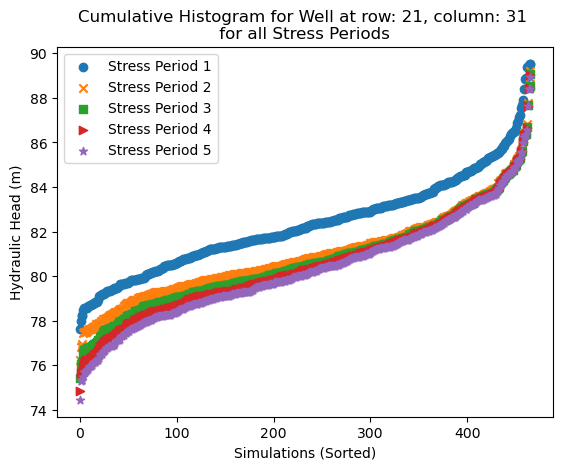

In [114]:
import seaborn as sns

wn = 844
#int(well_loc_df.loc[wn, 1]), int(well_loc_df.loc[wn, 0])
print(wn,int(well_loc_df.loc[wn, 1]), int(well_loc_df.loc[wn, 0]))

wnlist = [wn*numTS + i for i in range(numTS)]
markers = ['o','x','s','>','*']
for k,i in enumerate(StrPer):
    plt.scatter(range(len(well_head_df.loc[:,idx[str(wn),i]].index)),well_head_df.loc[:,idx[str(wn),i]].sort_values(),marker=markers[k],label='Stress Period '+str(i))

plt.ylabel('Hydraulic Head (m)')
plt.xlabel('Simulations (Sorted)')
plt.title('Cumulative Histogram for Well at row: ' +str(all_well_loc[wn][0])+ ", column: " + str(all_well_loc[wn][1])+ ' \n for all Stress Periods ')
plt.legend()
plt.show()


In [254]:
# mn = "D:/mfoutput/transientDrawdown/ScenarioSfr750SteadyPumpTest_0.nam"

# ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# reach = ztop[25] - 5

# m = flopy.modflow.Modflow.load(mn)

# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)
# xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
# patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')

# linecollection = xsect.plot_grid(color='black', lw=0.5)
# t = ax.set_title('Steady State Model - Row 25 Cross-Section - Hydraulic Heads for All Simulations')
# xlabel = ax.set_xlabel('Length (m)')
# ylabel = ax.set_ylabel('Elevation (m)')

# well_head_onlyRiv = well_head_df[river_well_loc[0]] 

# print(well_head_onlyRiv)

# for i in well_head_onlyRiv.index:#rand_list: #rand_list[:100]:
# #     modelname = "ScenarioSfrWell750Test3_"+str(i)
# #     fname = modws+'/'+modelname+'.hds'
# #     hdobj = flopy.utils.HeadFile(fname)
# #     head = hdobj.get_data()
#     wtup = xsect.plot_surface(well_head_onlyRiv.loc[i], lw=0.5, alpha=0.25)
#   # wtlow = xsect.plot_surface(head[2], lw=0.5, alpha=0.25, color='purple')
# plt.plot(np.arange(0,5000,100),reach,color='green',linestyle='dashed', lw=1.5)
# #plt.legend()


In [348]:
#display(well_head_noRiv)
#Testing stacking all the stressperiods together to increase the sample sizes
Stp_head_test_df = well_head_noRiv.copy()
noRivWellsInt = [i for i in AllWells if i not in drop_locs[0]]

column_idx = pd.MultiIndex.from_product([noRivWellsInt, stps_arr],
                           names=['wellnum', 'Stp'])
Stp_head_test_df.columns = column_idx
# Stp_head_test_df.columns = Stp_head_test_df.columns.astype('str')
#display(Stp_head_test_df)
Stp_head_test_df = Stp_head_test_df.stack(level='Stp').reset_index(drop=True)
display(Stp_head_test_df)
output_test = RevisedOutputdf.swaplevel(0,1).sort_index(0)
#display(RevisedOutputdf[25])
display(output_test.reset_index(drop=True))
#display(RevisedOutputdf.loc[idx[:,1],25])

Stp_head_test_df.columns = Stp_head_test_df.columns.astype('str')

wellnum        0          1          2          3          4          5     \
0        100.182137  99.934296  99.523903  99.018066  98.419556  97.901123   
1        100.151459  99.886238  99.441643  98.886230  98.224068  97.782120   
2        100.074760  99.801285  99.346443  98.784065  98.120491  97.683624   
3         99.995934  99.720131  99.262749  98.698975  98.035622  97.601242   
4         99.919518  99.642906  99.184723  98.620682  97.957764  97.525185   
...             ...        ...        ...        ...        ...        ...   
2325      97.303268  97.089455  96.736954  96.305161  95.796257  95.378418   
2326      97.295593  97.070824  96.689224  96.200821  95.600159  95.289917   
2327      97.257370  97.016594  96.611053  96.103004  95.496811  95.199776   
2328      97.204056  96.955391  96.540115  96.025749  95.418854  95.127190   
2329      97.147476  96.895004  96.475441  95.958733  95.352280  95.064072   

wellnum       6          7          8          9     ...       2002  \
0        97.360611  96.811172  96.260651  95.715614  ...  98.277473   
1        97.290688  96.769600  96.233421  95.694298  ...  98.195831   
2        97.203674  96.697235  96.175339  95.647736  ...  98.148132   
3        97.126083  96.626213  96.111755  95.591469  ...  98.107384   
4        97.052948  96.556892  96.046837  95.531105  ...  98.068253   
...            ...        ...        ...        ...  ...        ...   
2325     94.936981  94.483879  94.026176  93.569710  ...  95.764175   
2326     94.901588  94.470245  94.019852  93.565247  ...  95.673203   
2327     94.836914  94.430199  93.996971  93.551857  ...  95.621361   
2328     94.775978  94.383690  93.964081  93.529579  ...  95.581924   
2329     94.719971  94.337090  93.927483  93.501991  ...  95.547775   

wellnum       2003       2004       2005       2006       2007       2008  \
0        97.758751  97.218117  96.668709  96.118347  95.573586  95.042259   
1        97.709763  97.189774  96.652084  96.107559  95.565163  95.034416   
2        97.665199  97.151062  96.620407  96.082489  95.545311  95.018066   
3        97.626343  97.115013  96.587822  96.053658  95.520081  94.995888   
4        97.588799  97.079437  96.554543  96.022827  95.491676  94.969688   
...            ...        ...        ...        ...        ...        ...   
2325     95.345291  94.902740  94.448479  93.989571  93.531860  93.082321   
2326     95.305176  94.887085  94.442551  93.986855  93.529922  93.080368   
2327     95.260757  94.855843  94.423546  93.976143  93.523712  93.076134   
2328     95.224503  94.825737  94.400818  93.960243  93.513046  93.068878   
2329     95.192535  94.797638  94.377678  93.942230  93.499588  93.058990   

wellnum       2009       2010       2011  
0        94.537201  94.085373  93.755791  
1        94.529121  94.076775  93.746704  
2        94.514748  94.063240  93.733315  
3        94.494865  94.044838  93.715607  
4        94.470497  94.021790  93.693268  
...            ...        ...        ...  
2325     92.652252  92.265259  91.981522  
2326     92.650139  92.262970  91.979088  
2327     92.646561  92.259483  91.975517  
2328     92.641212  92.255013  91.971352  
2329     92.633774  92.249039  91.966057  

[2330 rows x 1941 columns]

C:\Users\davem\AppData\Local\Temp\ipykernel_3628\497981123.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  output_test = RevisedOutputdf.swaplevel(0,1).sort_index(0)


reach   1        2        3        4        5        6        7        8   \
0      1.0  11.8290  22.5360  33.3560  44.2930  55.2820  66.2220  76.9950   
1      1.0  11.7030  22.2740  32.9110  43.5920  54.2300  64.7020  74.8620   
2      1.0  11.5290  21.9360  32.4130  42.9330  53.4080  63.7120  73.7000   
3      1.0  11.3650  21.6190  31.9500  42.3300  52.6660  62.8360  72.6910   
4      1.0  11.2120  21.3240  31.5200  41.7700  51.9810  62.0280  71.7630   
...    ...      ...      ...      ...      ...      ...      ...      ...   
2325   1.0   1.9809   3.0863   4.3044   5.6221   7.0245   8.4955  10.0170   
2326   1.0   1.9770   3.0775   4.2849   5.5822   6.9515   8.3729   9.8249   
2327   1.0   1.9669   3.0570   4.2522   5.5348   6.8861   8.2857   9.7113   
2328   1.0   1.9545   3.0319   4.2136   5.4816   6.8168   8.1988   9.6055   
2329   1.0   1.9409   3.0048   4.1726   5.4258   6.7456   8.1113   9.5009   

reach      9       10  ...       41       42       43       44       45  \
0      87.459  97.408  ...  145.160  139.700  133.300  125.770  116.810   
1      84.543  93.541  ...  133.360  129.400  124.560  118.630  111.180   
2      83.205  92.020  ...  120.300  116.050  111.030  105.060   97.754   
3      82.064  90.750  ...  113.220  108.690  103.460   97.254   89.745   
4      81.019  89.592  ...  108.930  104.270   98.909   92.572   84.932   
...       ...     ...  ...      ...      ...      ...      ...      ...   
2325   11.572  13.137  ...   40.737   40.046   39.116   37.910   36.385   
2326   11.285  12.732  ...   40.399   39.805   38.955   37.812   36.331   
2327   11.139  12.549  ...   39.174   38.641   37.874   36.834   35.473   
2328   11.013  12.402  ...   38.069   37.502   36.706   35.642   34.266   
2329   10.891  12.262  ...   37.129   36.566   35.773   34.708   33.325   

reach       46      47      48      49      50  
0      105.970  92.506  74.972  52.979  52.979  
1      101.720  89.486  72.992  51.895  52.394  
2       88.638  76.978  61.345  41.892  43.120  
3       80.470  68.697  53.010  34.090  34.933  
4       75.536  63.655  47.886  29.301  29.848  
...        ...     ...     ...     ...     ...  
2325    34.545  32.715  30.895  29.086  29.086  
2326    34.521  32.707  30.893  29.085  29.085  
2327    33.800  32.128  30.454  28.773  28.877  
2328    32.595  30.939  29.299  27.675  27.842  
2329    31.642  29.967  28.304  26.655  26.785  

[2330 rows x 50 columns]

In [116]:
best_pars_dt = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}

In [365]:
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 100

rn = 32
strper_num = 0
#StrPer = [i+1 for i in range(stps, stps+numTS)]

#take the last stress period (-1) - welldf columns are strings 
SingleStpHeads = well_head_noRiv.loc[:,idx[:,StrPer[:]]]
SingleStpHeads.columns = SingleStpHeads.columns.droplevel('Stp').astype('str') #have to do this for the TreeRegressor to keep the wellnums
outputs = RevisedOutputdf.loc[idx[StrPer[:],:],rn].unstack('Stp')
#display(outputs)

imp_df, metrics_df, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, Stp_head_test_df, output_test[rn], best_pars_dt, 0.2, n)  

print('Total time: ' + str(time.time()-t0))


Shape of Input Samples: (2330, 1941)
Shape of Output Targets: (2330,)


KeyboardInterrupt: 

bias     0.092172
rmse    24.519182
r        0.966905
nse      0.934406
kge      0.958894
dtype: float64


0         1    2    3         4    5    6    7        8    9   ...  \
0     0.0  0.010869  0.0  0.0  0.000000  0.0  0.0  0.0  0.00503  0.0  ...   
1     0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000  0.0  ...   
2     0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000  0.0  ...   
3     0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000  0.0  ...   
4     0.0  0.000000  0.0  0.0  0.000316  0.0  0.0  0.0  0.00000  0.0  ...   
...   ...       ...  ...  ...       ...  ...  ...  ...      ...  ...  ...   
2007  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000  0.0  ...   
2008  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000  0.0  ...   
2009  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000  0.0  ...   
2010  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000  0.0  ...   
2011  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.00000  0.0  ...   

            90   91        92   93   94        95   96   97   98   99  
0     0.000000  0.0  0.009978  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
1     0.000000  0.0  0.000000  0.0  0.0  0.010812  0.0  0.0  0.0  0.0  
2     0.003215  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
3     0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
4     0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
...        ...  ...       ...  ...  ...       ...  ...  ...  ...  ...  
2007  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
2008  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
2009  0.000000  0.0  0.002002  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
2010  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
2011  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  

[1941 rows x 100 columns]

0         1    2    3         4    5    6    7    8    9  ...  \
0   0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
1   0.010869  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
2   0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
3   0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
4   0.000000  0.000000  0.0  0.0  0.000316  0.0  0.0  0.0  0.0  0.0  ...   
..       ...       ...  ...  ...       ...  ...  ...  ...  ...  ...  ...   
95  0.000000  0.010812  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
96  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
97  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
98  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   
99  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...   

        2002  2003      2004  2005      2006  2007  2008  2009  2010  2011  
0   0.000000   0.0  0.000000   0.0  0.000169   0.0   0.0   0.0   0.0   0.0  
1   0.000000   0.0  0.000000   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
2   0.000045   0.0  0.000000   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
3   0.000000   0.0  0.000000   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
4   0.000000   0.0  0.000000   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
..       ...   ...       ...   ...       ...   ...   ...   ...   ...   ...  
95  0.000000   0.0  0.000000   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
96  0.000000   0.0  0.001774   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
97  0.000000   0.0  0.000000   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
98  0.000000   0.0  0.000000   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
99  0.000056   0.0  0.000000   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  

[100 rows x 1941 columns]

Text(0.5, 1.0, 'Example Decision Tree Regression for Q at reach 25')

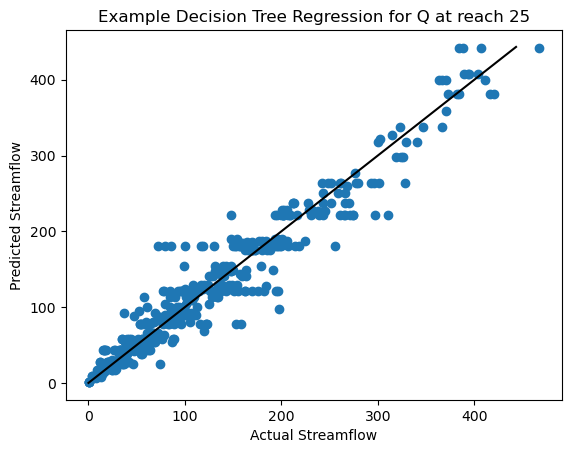

In [354]:
print(metrics_df.mean())
display(imp_df)
test = imp_df.copy().T
#test.columns =Stp_head_test_df.columns
#test.columns = well_head_noRiv.columns
#test = pd.DataFrame(test.sum(axis = 0) / n)

display(test)


# #imp_df.to_pickle('Drawdown_DT_Impdf.pkl')
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

## RandomTree

Shape of Input Samples: (2330, 1941)
Shape of Output Targets: (2330,)
Total time: 17.882938623428345
bias    -0.224365
rmse    51.727501
r        0.843582
nse      0.709392
kge      0.802406
dtype: float64


Text(0.5, 1.0, 'Example Random Decision Tree Regression for Q at reach 25')

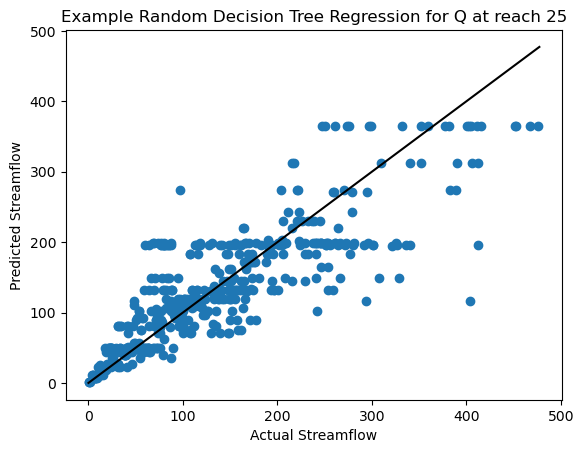

In [358]:
# RANDOM Tree 
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()


#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
best_pars_dt_rand = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1, 'max_depth': 7, 'criterion': 'friedman_mse'}
    
imp_df_rand, metrics_df_rand, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, Stp_head_test_df, output_test[rn], best_pars_dt_rand, 0.2, n)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rand.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)
C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


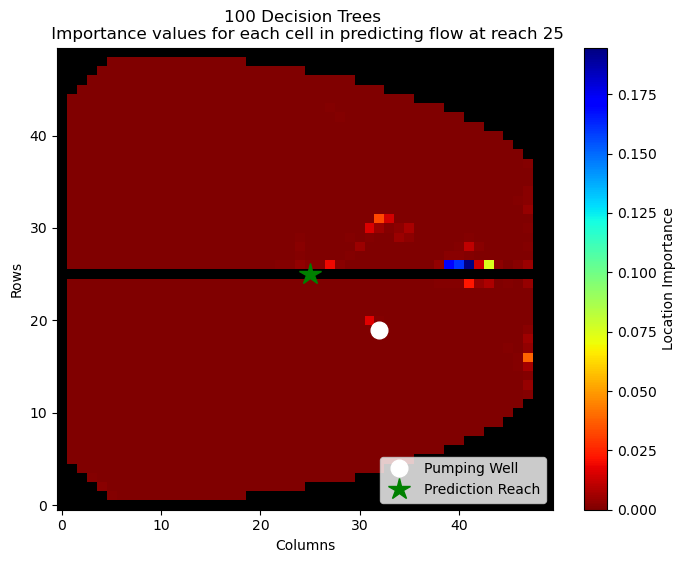

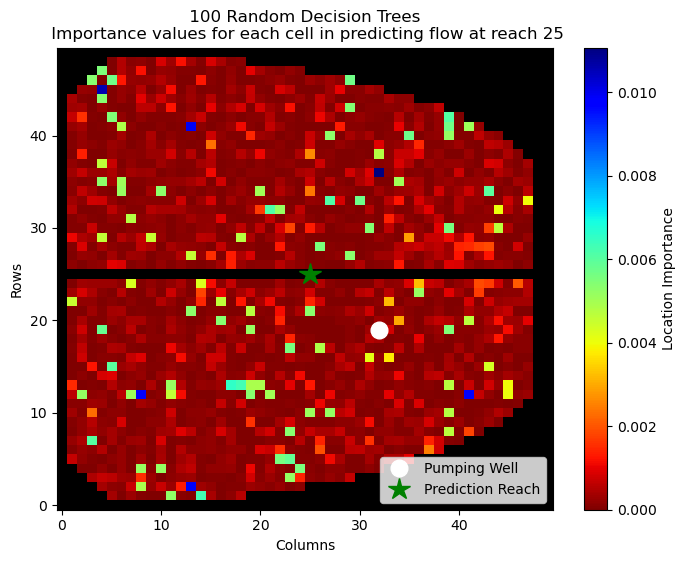

In [359]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
n = 100

title = '100 Decision Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)
#wellmesh_df = np.ndarray((len(StrPer),50,50))

#for k,i in enumerate(StrPer):
 #   wellmesh_df[k] = plotImportance(test.xs(i,level='Stp'),SingleStpHeads, well_loc_df,numTS,n,rn,title)
wellmesh_df = plotImportance(imp_df,Stp_head_test_df, well_loc_df,numTS,n,rn,title)

title_rand = ' 100 Random Decision Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_rand = plotImportance(imp_df_rand,well_head_noRiv, well_loc_df,numTS,n,rn,title_rand)


In [161]:
# # import importlib
# # import treeFuncs
# # importlib.reload(treeFuncs)
# # from treeFuncs import plotImportance

# # numTS = 1
# # n = 100

# # title = '100 Decision Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)

# # wellmesh_df = plotImportance(imp_df,well_head_noRiv, well_loc_df,numTS,n,rn,title)
# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# #PLotting out the result grid
# #display(imp_df)
# dt_total_imp_df = imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
# #Sum up all the stress periods for each well location
# #dt_AllTSimp = dt_total_imp_df.groupby(int(dt_total_imp_df.index.values) // numTS).sum()
# dt_AllTSimp = dt_total_imp_df
# #get indicies of every feature per TS (stressperiod)
# # TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

# # for i in range(numTS):
# #     featInTS = np.intersect1d(dt_total_imp_df.index, TSIndices+i)
# #     print(featInTS)
# #     print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
# #     print("Sum of Importances in Stress period " + str(i) + ": " + str(dt_total_imp_df.loc[featInTS].sum()))
    
# #Should probably use this now - it tracks the well location number with the index
# #well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])


# #feature importance Mapping
# wellmesh_dt = np.ndarray((50,50))
# wellmesh_dt[:,:] = -1e30
# #all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

# for k in dt_AllTSimp.index:
#         wellmesh_dt[int(well_loc_df.loc[int(k), 1]), int(well_loc_df.loc[int(k), 0])] = dt_AllTSimp.loc[k]

# cmap2 = cm.get_cmap("jet_r")#,lut=20)
# cmap2.set_under("k")

# vmax = np.max(dt_AllTSimp)
# #vmax = 0.1
# vmin = np.min(dt_AllTSimp)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,wellmesh_dt,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
# plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar(label = "Location Importance")
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.legend()
# plt.title('Importance values for each cell in predicting flow at reach ' + str(rn))


In [62]:
# wellmesh_AllTs = np.ndarray((numTS,50,50))
# wellmesh_AllTs[:,:,:] = -1e30
# #all_well_locNoRiv = np.delete(all_well_loc, drop_locs, axis = 0)
# #for i in range(all_well_loc.shape[0]):

# #featInTS = np.intersect1d(usedFeatures, featIndices)
# #pd.DataFrame(importanceArr[featInTS])#just going to use step period 0
# for i in range(numTS):
#     featInTS = np.intersect1d(dt_total_imp_df.index, TSIndices+i)    
#     for k in featInTS:
#         wellnum = k // numTS
#         wellmesh_AllTs[i,int(well_loc_df.loc[wellnum, 1]), int(well_loc_df.loc[wellnum, 0])] = dt_total_imp_df.loc[k] #np.sum(importanceList[:,i]) 
    

In [175]:
# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# #PLotting out the result grid

# cmap2 = cm.get_cmap("jet_r")#,lut=20)
# cmap2.set_under("k")

# vmax = np.max(dt_AllTSimp)
# #vmax = 1
# vmin = np.min(dt_AllTSimp)

# for i in range(numTS):
#     plt.figure(figsize=(8,6))
#     plt.pcolormesh(KK,GG,wellmesh_AllTs[i],vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
#     plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
#     plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
#     # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#     #plt.show()
#     #plt.imshow(wellmesh, cmap='RdBu')
#     plt.colorbar(label = "Location Importance")
#     plt.xlabel('Columns')
#     plt.ylabel('Rows')
#     plt.title('Importance values for each cell in predicting flow at reach ' + str(rn)+' for Stress Period: ' +str(i))


In [176]:
# mostImportant = importance_df.sort_values(ascending=False)[:10]
# print(len(mostImportant.index))

# AllStrPerMI = mostImportant.index*numTS #for transient
# print(AllStrPerMI)
# first = AllStrPerMI
# for i in range(1,numTS+1):
#     AllStrPerMI = np.append(AllStrPerMI,(first+(i)))#add the location of the ather stress period heads
# #temp = [k for i in mostImportant.index for k in np.arange(i,i+numTS).tolist()] #very proud of this double list comprehension - expand it back out to include the all the time series
# print(mostImportant)
# print(AllStrPerMI)

In [177]:
# # Split dataset into training set and test set, default here is 30% test
# t0 = time.time()
# n = 100

# PredList = []
# NSEList = []
# miimportanceList = []
# miimportanceListAll = []

# #new_zone_q = ReachQdf.loc[well_head_noRiv.index]
# mostImpWellHead = well_head_df.loc[:,AllStrPerMI]
# print(mostImpWellHead)
# for i in range(n):
#     well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
#     X_train, X_test, y_train, y_test = train_test_split(mostImpWellHead,outputs, test_size=0.3, random_state=0)
#     # Create Random Forest Object
#     Tree = DecisionTreeRegressor(
#     #max_depth = 2 {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
#     )

#     # Train Decision Tree Classifer
#     Tree = Tree.fit(X_train,y_train)

#     #Predict the response for test dataset
#     y_pred = Tree.predict(X_test)
#     PredList.append(y_pred)
#     NSEList.append(NSE(y_pred, y_test))
#     #feature importance
#     #importanceList.append(Tree.feature_importances_)
#     implist = Tree.feature_importances_
#     temp = [sum(implist[i:i+numTS]) for i in range(0, len(implist), numTS)]
#     miimportanceList.append(temp)
#     miimportanceListAll.append(implist)
    
    
# #well head Tree NSE
  
# #print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
# print("Average NSE: ", np.mean(NSEList))

# t1 = time.time()

# total = t1-t0
# print('Total time: ' + str(total))

In [178]:
# #print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[10] > 0].index) / len(new_zone_q.index)))
# plt.figure()
# plt.scatter(y_test, y_pred, color='r')
# outmax = np.max(test_q)
# plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# title = "Decision Tree for Q at reach " + str(rn) +" Using Top 10 well sites - NSE: " + str(round(NSEList[-1],2))
# plt.title(title)
# #plt.yscale('log')
# #plt.xscale('log')
# #plt.legend()
# plt.show()


# #WellStreamimportance = Tree.feature_importances_
# #print(WellStreamimportance)
# miimportance_df = pd.DataFrame(miimportanceList).sum()
# #miimportance_df['wellnum'] = mostImpWellHead.columns
# print(miimportance_df)
# plt.plot(miimportance_df, '.k')

In [33]:
# feature importance Mapping
# miwellmesh = np.ndarray((50,50))
# miwellmesh[:,:] = -1e30
# #all_well_locNoRiv = np.delete(all_well_loc, river_well_loc[0], axis = 0)
# #for i in range(all_well_loc.shape[0]):
# for i,k in enumerate(mostImportant.index):
#     #if(all_well_loc[i,1] != 25):
#     miwellmesh[int(all_well_locNoRiv[k, 1]), int(all_well_locNoRiv[k, 0])] = miimportance_df[i] #np.sum(importanceList[:,i])  


In [179]:
# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# #PLotting out the result grid

# cmap2 = cm.get_cmap("jet_r",lut=10)
# cmap2.set_under("k")

# vmax = np.max(miimportance_df)
# #vmax = 1
# vmin = np.min(miimportance_df)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,miwellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Importance values')


In [ ]:

# result = permutation_importance(
#     Tree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )
# print(result.importances_mean)

# wellmesh = np.ndarray((50,50))
# wellmesh[:,:] = -1e30

# for i in range(all_well_loc.shape[0]):
#     wellmesh[int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = result.importances_mean[i] #np.sum(importanceList[:,i])

# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# cmap2 = cm.get_cmap("jet_r",lut=10)
# cmap2.set_under("k")

# vmax = np.max(0.001)
# vmin = np.min(WellStreamimportance)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,wellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Permutation Importance values')

## Gradient Boosting

In [213]:
best_pars_gr = {'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 45, 'max_leaf_nodes': 52, 'max_features': 1.0, 'max_depth': 3, 'loss': 'squared_error', 'criterion': 'friedman_mse'}
#best_pars_gr = {'subsample': 0.5, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 6, 'loss': 'huber', 'criterion': 'friedman_mse'}

Shape of Input Samples: (2330, 1941)
Shape of Output Targets: (2330,)
Total time: 426.3725497722626
bias     1.323929
rmse    12.739125
r        0.991879
nse      0.983246
kge      0.969139
dtype: float64


Text(0.5, 1.0, 'Example Gradient Boosting Tree Regression for Q at reach 25')

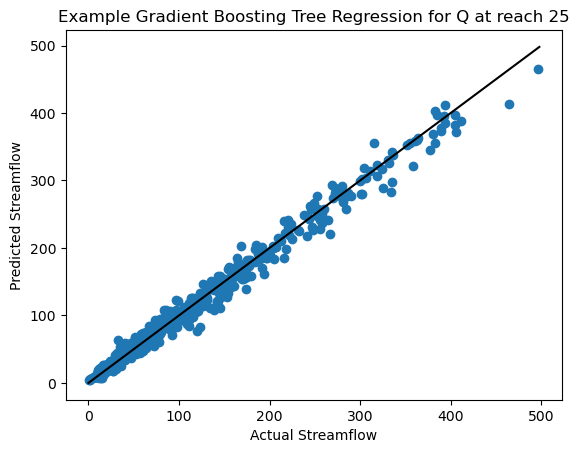

In [360]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
    
imp_df_gr, metrics_df_gr, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, Stp_head_test_df, output_test[rn], best_pars_gr, 0.2, n)  

#imp_df_gr, metrics_df_gr, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, SingleStpHeads, outputs, best_pars_gr, 0.2, n)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_gr.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Gradient Boosting Tree Regression for Q at reach " + str(rn)
plt.title(title)


In [183]:
#gr_imp_df.to_pickle('Drawdown_GB_Impdf.pkl')

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


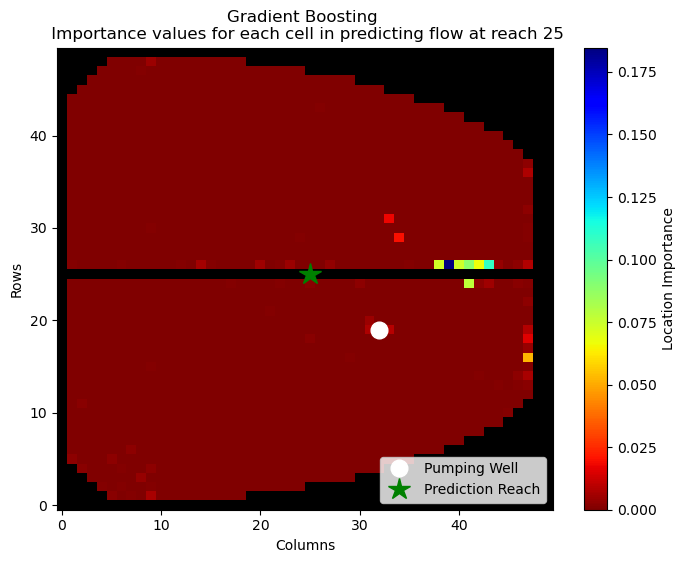

In [361]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
#n = 100

title = 'Gradient Boosting \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_gr = plotImportance(imp_df_gr,SingleStpHeads, well_loc_df,numTS,n,rn,title)



## Random Forest - Transient Drawdown Scenario

In [216]:
best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
#best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}

Shape of Input Samples: (2330, 1941)
Shape of Output Targets: (2330,)
Total time: 633.0970213413239
bias     0.460308
rmse    15.509296
r        0.989455
nse      0.976794
kge      0.941417
dtype: float64


Text(0.5, 1.0, 'Random Forest Regression for predicting Q at reach 25')

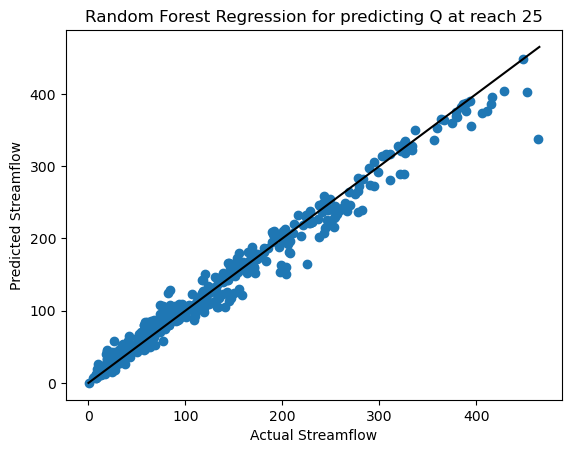

In [362]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

#Splitter is random and max features is set to 1 (note that 1.0 is all in the new default all features in Sklearn so this is a little confusing)
    
imp_df_rf, metrics_df_rf, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, Stp_head_test_df, output_test[rn], best_pars_rf, 0.2, n)  

#imp_df_rf, metrics_df_rf, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, SingleStpHeads, outputs, best_pars_rf, 0.2, n)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rf.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Random Forest Regression for predicting Q at reach " + str(rn)
plt.title(title)

In [187]:
#rf_imp_df.to_pickle('Drawdown_RF_Impdf.pkl')


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


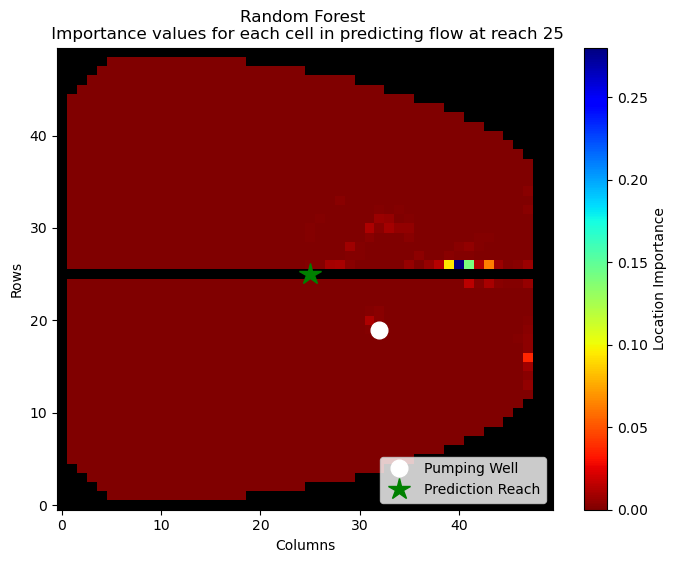

In [363]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
#n = 100

title = 'Random Forest \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_rf = plotImportance(imp_df_rf,SingleStpHeads, well_loc_df,numTS,n,rn,title)

C:\Users\davem\AppData\Local\Temp\ipykernel_3628\1411964329.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_bd = cm.get_cmap("gray")#,lut=20)


[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.96419839 0.98651288 0.95561707 1.        ]
 [0.95976932 0.98479047 0.95044983 1.        ]
 ...
 [0.03137255 0.2044752  0.44372165 1.        ]
 [0.03137255 0.19635525 0.43166474 1.        ]
 [0.03137255 0.18823529 0.41960784 1.        ]]


[Text(0.0, 0, ''),
 Text(0.15, 0, 'Random Forest'),
 Text(0.5, 0, 'Gradient Boosted'),
 Text(0.85, 0, 'Decision Tree'),
 Text(1.0, 0, '')]

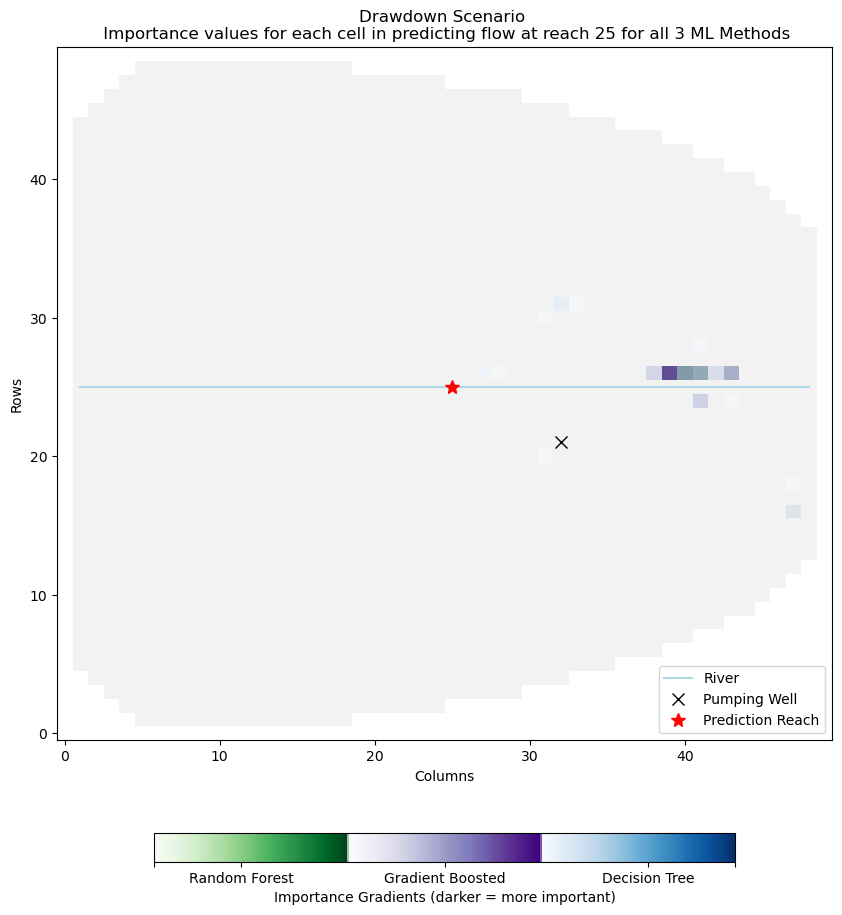

In [364]:
#set up the meshgrid   
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)



river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.01)
vmaxrf = np.max(wellmesh_rf)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_gr, wellmesh_gr < 0.01)
vmaxgr = np.max(wellmesh_gr)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_df, wellmesh_df < 0.01)
vmaxdt = np.max(wellmesh_df)

vmin = 0.01
# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128))))
print(colors)

mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = 1.5,vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmaxdt, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmaxrf, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmaxgr, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Drawdown Scenario \n Importance values for each cell in predicting flow at reach ' + str(rn) + ' for all 3 ML Methods')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.15,0.5,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Random Forest', 'Gradient Boosted','Decision Tree',''])
#plt.legend()